In [1]:
# imports 1

import numpy as np
import pandas as pd


In [2]:
# imports 2

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
# imports 3

import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
import statsmodels.api as sm

In [4]:
# imports 4

from xgboost import XGBClassifier

import joblib

In [7]:
from collections import Counter
import scipy.stats as stats

In [69]:
from pathlib import Path
import argparse

### <span style = "color:green"> Read and prepare the dataset from the University of Nevada, UNR-IDD.csv, downloaded from: https://drive.google.com/file/d/1Xumpy7su7C5_Yo00PwjeJfJyaMU6Cn8w/view?usp=sharing. </span>

In [5]:
pd.options.display.float_format = "{:.2f}".format

In [12]:

%%sh
wc -l ../data/raw/UNR-IDD.csv

   37412 ../data/raw/UNR-IDD.csv


In [13]:
# import data as pd dataframe

rawdata_path = "../data/raw/UNR-IDD.csv"
raw_df = pd.read_csv(rawdata_path, index_col=None)

In [50]:
# save raw_df as csv to folder for further use

raw_df.to_csv("../data/raw/raw_df.csv", index=False)

In [16]:
# look at the data

raw_df.head()

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


In [17]:
raw_df.shape

(37411, 34)

In [18]:
# get an idea of the features  and the target

raw_df.columns

Index(['Switch ID', 'Port Number', 'Received Packets', 'Received Bytes',
       'Sent Bytes', 'Sent Packets', 'Port alive Duration (S)',
       'Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors',
       'Packets Tx Errors', 'Delta Received Packets', 'Delta Received Bytes',
       'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Delta Packets Rx Dropped',
       ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors',
       'Delta Packets Tx Errors', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest',
       'Latest bytes counter', 'is_valid', 'Table ID', 'Active Flow Entries',
       'Packets Looked Up', 'Packets Matched', 'Max Size', 'Label',
       'Binary Label'],
      dtype='object')

In [19]:
# get numerical and categorical columns
num_cols = list(raw_df._get_numeric_data().columns)
categ_cols = [colum for colum in raw_df.columns if colum not in num_cols]  #easy way of getting the categorical column names
print("categorical",
categ_cols , "\n"
"numerical",
num_cols)

categorical ['Switch ID', 'Port Number', 'Label', 'Binary Label'] 
numerical ['Received Packets', 'Received Bytes', 'Sent Bytes', 'Sent Packets', 'Port alive Duration (S)', 'Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors', 'Delta Received Packets', 'Delta Received Bytes', 'Delta Sent Bytes', 'Delta Sent Packets', 'Delta Port alive Duration (S)', 'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors', 'Delta Packets Tx Errors', 'Connection Point', 'Total Load/Rate', 'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest', 'Latest bytes counter', 'is_valid', 'Table ID', 'Active Flow Entries', 'Packets Looked Up', 'Packets Matched', 'Max Size']


In [20]:
# create the labels for binary labels and label

labels_binlab = raw_df["Binary Label"]
labels_labcat = raw_df["Label"]

In [21]:
# encode the labels with values

labels_binlab = labels_binlab.replace(to_replace= ["Attack", "Normal"], value= [1 , 0])
labels_labcat = labels_labcat.replace(to_replace= ['Blackhole', 'Diversion', 'Normal', 'Overflow', 'PortScan', 'TCP-SYN'], value= [1 , 2, 3, 4, 5, 0])

In [22]:
# save all new dataframes

labels_binlab.to_csv("../data/processed/labels_binlab.csv", index=False)
labels_labcat.to_csv("../data/processed/labels_labcat.csv", index=False)

In [63]:
# check the representation of label clases

print(labels_binlab.value_counts()), print(labels_labcat.value_counts())

1    33638
0     3773
Name: Binary Label, dtype: int64
5    9500
0    9081
1    8420
2    5615
3    3773
4    1022
Name: Label, dtype: int64


(None, None)

In [23]:
# create and use a results_dict to output the type of the attack, or normal state, as in
# results_dict[model.predict(single_data_sample)] or query_answer = results_dict[model.predict(single_data_sample)]
# then use query_answer to output the answer to text / email, voice message or red/green flag in dashboard.

results_dict = {key : value for key, value in zip([1 , 2, 3, 4, 5, 0], ['Blackhole', 'Diversion', 'Normal', 'Overflow', 'PortScan', 'TCP-SYN'])}
results_dict

{1: 'Blackhole',
 2: 'Diversion',
 3: 'Normal',
 4: 'Overflow',
 5: 'PortScan',
 0: 'TCP-SYN'}

### <span style = "color:green"> Eliminate unnecesary features. </span>

In [25]:
# create reduced dataset without columns that provide no information.
# dropping also switch  id and port id

red_new_df = raw_df[[#'Switch ID', # this is no general info but data from setup used to model data
                        #'Port Number', # this is no general info but data from setup used to model data
                        'Received Packets', 
                        'Received Bytes', 
                        'Sent Bytes', 
                        'Sent Packets', 
                        'Port alive Duration (S)',
                        #'Packets Rx Dropped', #empty feature
                        #'Packets Tx Dropped', #empty feature
                        #'Packets Rx Errors', #empty feature
                        #'Packets Tx Errors', #empty feature
                        'Delta Received Packets', 
                        'Delta Received Bytes',
                        'Delta Sent Bytes', 
                        'Delta Sent Packets',
                        #'Delta Port alive Duration (S)', # new # feature witn only one value for the set 
                        #'Delta Packets Rx Dropped', #empty feature
                        #' Delta Packets Tx Dropped', #empty feature
                        #'Delta Packets Rx Errors',#empty feature
                        #'Delta Packets Tx Errors', #empty feature
                        #'Connection Point', # new # information not general bur associated with test setup for data generation
                        'Total Load/Rate',
                        'Total Load/Latest', 
                        'Unknown Load/Rate', 
                        'Unknown Load/Latest',
                        'Latest bytes counter', 
                        #'is_valid', # info from data generation set up
                        #'Table ID', #empty feature
                        #'Active Flow Entries', # new # unknown feature source not replicable in real data?
                        'Packets Looked Up', 
                        'Packets Matched', 
                        #'Max Size', # # unknown feature source not replicable in real data?
                        'Label',
                        'Binary Label']]

In [26]:
# save  new reduced dataset as a dataframe

red_new_df.to_csv("../data/processed/red_new_df.csv", index=False)

In [27]:
# drop the label columns creating the reduced features dataframe

red_new_features = red_new_df.drop(['Label', "Binary Label"], axis=1)
red_new_features.to_csv("../data/processed/red_new_features.csv", index=False)

### <span style = "color:green"> check correlation matrix for features. </span>

In [56]:
corr_features = red_new_features.corr()
corr_features.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/vj/t577mz3n2zjct20w2tzmy1mw0000gn/T/ipykernel_73931/1575625545.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_features.style.background_gradient(cmap='coolwarm').set_precision(2)


,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Delta Received Packets,Delta Received Bytes,Delta Sent Bytes,Delta Sent Packets,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Packets Looked Up,Packets Matched
Received Packets,1.00,0.24,0.26,0.59,0.20,0.18,0.01,0.00,0.09,0.02,0.03,0.02,0.03,0.02,0.74,0.74
Received Bytes,0.24,1.00,0.68,0.39,0.75,-0.04,0.10,0.01,-0.06,0.02,0.01,0.02,0.01,0.02,0.38,0.38
Sent Bytes,0.26,0.68,1.00,0.49,0.74,-0.07,0.01,0.09,-0.04,0.03,0.03,0.03,0.03,0.03,0.45,0.45
Sent Packets,0.59,0.39,0.49,1.00,0.29,0.03,0.01,0.02,0.10,0.02,0.03,0.02,0.03,0.02,0.94,0.94
Port alive Duration (S),0.20,0.75,0.74,0.29,1.00,-0.12,0.01,0.01,-0.12,0.00,-0.02,0.00,-0.02,0.00,0.29,0.29
Delta Received Packets,0.18,-0.04,-0.07,0.03,-0.12,1.00,0.10,0.04,0.60,-0.01,-0.02,-0.01,-0.02,-0.01,0.04,0.04
Delta Received Bytes,0.01,0.10,0.01,0.01,0.01,0.10,1.00,-0.07,0.04,0.01,-0.00,0.01,-0.00,0.01,0.01,0.01
Delta Sent Bytes,0.00,0.01,0.09,0.02,0.01,0.04,-0.07,1.00,0.11,0.27,0.20,0.27,0.20,0.27,0.01,0.01
Delta Sent Packets,0.09,-0.06,-0.04,0.10,-0.12,0.60,0.04,0.11,1.00,-0.01,-0.02,-0.01,-0.02,-0.01,0.04,0.04
Total Load/Rate,0.02,0.02,0.03,0.02,0.00,-0.01,0.01,0.27,-0.01,1.00,0.65,1.00,0.65,1.00,0.02,0.02


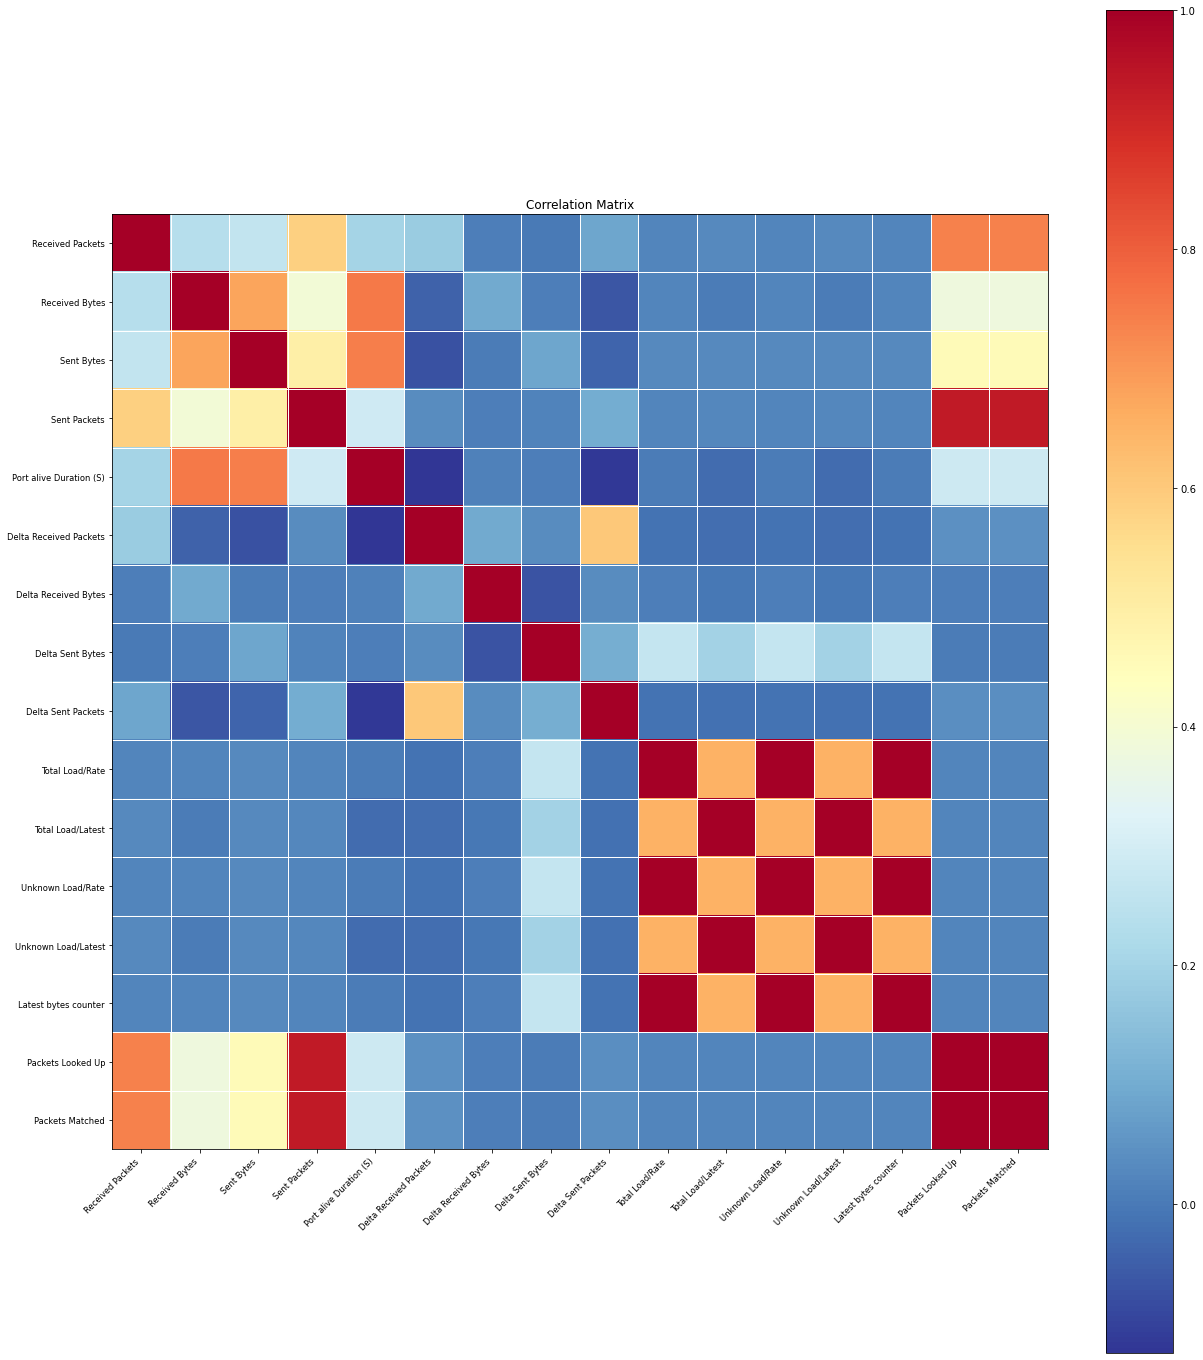

In [75]:


sm.graphics.plot_corr(corr_features, xnames=list(corr_features.columns))

plt.rc("figure", figsize=(17, 18))
plt.show()

### <span style = "color:green"> check correlation matrix for features and labels. </span>

In [62]:
extended_data = red_new_features
extended_data["binary_labels"] =  labels_binlab
extended_data["multi_labels"] =  labels_labcat

corr_features2 = extended_data.corr()
corr_features2.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/vj/t577mz3n2zjct20w2tzmy1mw0000gn/T/ipykernel_73931/2213431444.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_features2.style.background_gradient(cmap='coolwarm').set_precision(2)


,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Delta Received Packets,Delta Received Bytes,Delta Sent Bytes,Delta Sent Packets,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Packets Looked Up,Packets Matched,binary_labels,multi_labels
Received Packets,1.00,0.24,0.26,0.59,0.20,0.18,0.01,0.00,0.09,0.02,0.03,0.02,0.03,0.02,0.74,0.74,-0.68,0.20
Received Bytes,0.24,1.00,0.68,0.39,0.75,-0.04,0.10,0.01,-0.06,0.02,0.01,0.02,0.01,0.02,0.38,0.38,-0.39,-0.02
Sent Bytes,0.26,0.68,1.00,0.49,0.74,-0.07,0.01,0.09,-0.04,0.03,0.03,0.03,0.03,0.03,0.45,0.45,-0.47,-0.01
Sent Packets,0.59,0.39,0.49,1.00,0.29,0.03,0.01,0.02,0.10,0.02,0.03,0.02,0.03,0.02,0.94,0.94,-0.92,0.20
Port alive Duration (S),0.20,0.75,0.74,0.29,1.00,-0.12,0.01,0.01,-0.12,0.00,-0.02,0.00,-0.02,0.00,0.29,0.29,-0.33,-0.15
Delta Received Packets,0.18,-0.04,-0.07,0.03,-0.12,1.00,0.10,0.04,0.60,-0.01,-0.02,-0.01,-0.02,-0.01,0.04,0.04,0.05,0.22
Delta Received Bytes,0.01,0.10,0.01,0.01,0.01,0.10,1.00,-0.07,0.04,0.01,-0.00,0.01,-0.00,0.01,0.01,0.01,0.00,0.04
Delta Sent Bytes,0.00,0.01,0.09,0.02,0.01,0.04,-0.07,1.00,0.11,0.27,0.20,0.27,0.20,0.27,0.01,0.01,0.00,0.03
Delta Sent Packets,0.09,-0.06,-0.04,0.10,-0.12,0.60,0.04,0.11,1.00,-0.01,-0.02,-0.01,-0.02,-0.01,0.04,0.04,0.05,0.21
Total Load/Rate,0.02,0.02,0.03,0.02,0.00,-0.01,0.01,0.27,-0.01,1.00,0.65,1.00,0.65,1.00,0.02,0.02,-0.03,-0.07


### <span style = "color:red"> TBD.  Need to ad Renato's EDA work here (applied to current reduced feature dataset). </span>

### <span style = "color:green"> Select an appropriate ML classification model for the task and the data. </span>

In [28]:
# create train and test data for multi class labels using reduced features dataframe

X_red_new_train, X_red_new_test, y_red_new_train, y_red_new_test = train_test_split(red_new_features,labels_labcat, random_state= 0 , test_size= 0.2)

# save the test and train sets

sets = [X_red_new_train,X_red_new_test,y_red_new_train,y_red_new_test]
names = list(str("X_red_new_train,X_red_new_test,y_red_new_train,y_red_new_test").split(','))
for idx in range(len(sets)):
    sets[idx].to_csv("../data/processed/" + names[idx] + ".csv", index=False)

### <span style = "color:green"> Run simple logistic regression model on train and test it. </span>

In [30]:
# run Logistic Regression model for multi class labels WITHOUT STANDARIZATION

lgr_no_pipeline = Pipeline(steps = [ 
        ("logistic_regression", LogisticRegression(class_weight= "balanced", random_state= 0, max_iter = 4000))])


lgr_no_pipeline.fit(X_red_new_train, y_red_new_train)
y_red_new_pred = lgr_no_pipeline.predict(X_red_new_test)
print(classification_report(y_red_new_test, y_red_new_pred))

              precision    recall  f1-score   support

           0       0.66      0.13      0.22      1808
           1       0.34      0.11      0.17      1681
           2       0.27      0.86      0.41      1111
           3       0.44      0.99      0.61       770
           4       0.05      0.05      0.05       202
           5       0.67      0.41      0.51      1911

    accuracy                           0.39      7483
   macro avg       0.41      0.42      0.33      7483
weighted avg       0.49      0.39      0.34      7483



/Users/joaquingianantonio/tensor_flow/env2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# run Logistic Regression model for multi class labels WITH STANDARIZATION
lgr_yes_pipeline = Pipeline(steps = [ ("numeric", StandardScaler() ),
        ("logistic_regression", LogisticRegression(class_weight= "balanced", random_state= 0, max_iter = 600))])


lgr_yes_pipeline.fit(X_red_new_train, y_red_new_train)
y_yes_red_new_pred = lgr_yes_pipeline.predict(X_red_new_test)
print(classification_report(y_red_new_test, y_yes_red_new_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1808
           1       0.70      0.54      0.61      1681
           2       0.56      0.55      0.55      1111
           3       1.00      1.00      1.00       770
           4       0.11      0.59      0.19       202
           5       0.90      0.53      0.67      1911

    accuracy                           0.66      7483
   macro avg       0.66      0.67      0.63      7483
weighted avg       0.74      0.66      0.68      7483



### <span style = "color:green"> Perform TPOT analysis and select a better model, fine tuned. </span>

In [32]:
!pip install TPOT


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [34]:


%%time
from sklearn.metrics import make_scorer


from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, 
                      population_size=8,
                      scoring=None,
                      verbosity=2,
                      random_state=42)
tpot.fit(X_red_new_train, y_red_new_train)
print(f"Tpop score on test data: {tpot.score(X_red_new_test, y_red_new_test):.2f}")
tpot.export('tpot_network_analytics.py')

/Users/joaquingianantonio/tensor_flow/env2/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


Optimization Progress:   0%|          | 0/48 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8883656183559466

Generation 2 - Current best internal CV score: 0.905239465743097

Generation 3 - Current best internal CV score: 0.905239465743097

Generation 4 - Current best internal CV score: 0.905239465743097

Generation 5 - Current best internal CV score: 0.9093493283269428

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.3, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
Tpop score on test data: 0.91
CPU times: user 18min 25s, sys: 1min 25s, total: 19min 50s
Wall time: 16min 54s


/Users/joaquingianantonio/tensor_flow/env2/lib/python3.8/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [35]:
cat tpot_network_analytics.py

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.9093493283269428
exported_pipeline = RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.3, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [37]:
# train xgboos classifier model recommended by TPOT // MODEL PARAMETERS TAKEN FROM ANOTHER TPOT RUN

model_xgbc_01 = XGBClassifier(learning_rate=1.0, max_depth=5, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, verbosity=0)
# Fix random state in exported estimator
if hasattr(model_xgbc_01, 'random_state'):
    setattr(model_xgbc_01, 'random_state', 42)

model_xgbc_01.fit(X_red_new_train, y_red_new_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [38]:
# check metrics for trained model

results_new_red = model_xgbc_01.predict(X_red_new_test) # eview data names
print(classification_report(y_red_new_test, results_new_red)) # review data names

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1808
           1       0.99      0.98      0.98      1681
           2       0.98      0.97      0.98      1111
           3       1.00      1.00      1.00       770
           4       0.97      0.82      0.89       202
           5       0.91      0.93      0.92      1911

    accuracy                           0.95      7483
   macro avg       0.96      0.94      0.95      7483
weighted avg       0.95      0.95      0.95      7483



In [39]:
# save fina model with joblib

joblib.dump(model_xgbc_01, "model_xgbc_01.joblib")

['model_xgbc_01.joblib']

In [47]:
# get one sample data point from the test set by entering the sample id, valid id in range(len(test_data))
# def get_test_sample(sample_id):

sam = 345
sample1 = X_red_new_test.iloc[[sam]]
tag1 = y_red_new_test.iloc[[sam]]
print(type(sample1),"\n", sample1, "\n",tag1)

<class 'pandas.core.frame.DataFrame'> 
        Received Packets  Received Bytes  Sent Bytes  Sent Packets  \
19668               449         6335491       33279           289   

       Port alive Duration (S)  Delta Received Packets  Delta Received Bytes  \
19668                      284                       4                   556   

       Delta Sent Bytes  Delta Sent Packets  Total Load/Rate  \
19668               560                   4                0   

       Total Load/Latest  Unknown Load/Rate  Unknown Load/Latest  \
19668                  0                  0                    0   

       Latest bytes counter  Packets Looked Up  Packets Matched  
19668                     0               2494             2338   
 19668    2
Name: Label, dtype: int64


<span style = "color:blue"> when preparing the clean version of the notebook tpot returned a different ensembled tree classificator.  trying it out here. </span>

In [49]:
from sklearn.ensemble import RandomForestClassifier

exported_pipeline = RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.3, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_red_new_train, y_red_new_train)
results_rmdf = exported_pipeline.predict(X_red_new_test)
print(classification_report(y_red_new_test, results_rmdf))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1808
           1       0.96      0.96      0.96      1681
           2       0.97      0.91      0.94      1111
           3       1.00      1.00      1.00       770
           4       0.94      0.49      0.64       202
           5       0.88      0.89      0.89      1911

    accuracy                           0.91      7483
   macro avg       0.93      0.86      0.88      7483
weighted avg       0.92      0.91      0.91      7483



<span style = "color:blue"> Metrics from the xgboost ensembled classifier are better.  We continue using xgboost. </span>

### <span style = "color:green"> Define functions for model deployment. </span>

In [64]:
def sample_generator(id):  # the function in model.py is updated to work in a different environment with additional lines of code
    """
    Sample generator, receives an integer as input and
    returns a tuple with a sample in dataframe format and a string with the type of network event.
    """
    
    samples = X_red_new_test
    labels = y_red_new_test
    results_dict =    {
                        1: 'Blackhole',
                        2: 'Diversion',
                        3: 'Normal',
                        4: 'Overflow',
                        5: 'PortScan',
                        0: 'TCP-SYN'
                        }
    if id in range(samples.shape[0]):
        sample = samples.iloc[[id]]
        label = results_dict[int(labels.iloc[[id]].values)]
        return sample , label
    else:
        print("Sample ID excedes number of samples")

In [73]:
def predi(sample): # the function in model.py is updated to work in a different environment with additional lines of code
    """
    predi function: takes a sample network interaction in the form of a dataframe and 
    retuns string with the prediction of the network event.
    
    """
    
    
    
    

    model = model_xgbc_01

    results_dict =    {
                        1: 'Blackhole',
                        2: 'Diversion',
                        3: 'Normal',
                        4: 'Overflow',
                        5: 'PortScan',
                        0: 'TCP-SYN'
                        }

    result_sample = results_dict[model.predict(sample)[0]]   #result_sample = results_dict[model.predict(sample)[0]]

    return result_sample   # use this for model

In [67]:
def get_sample_prediction(id: int):
    sample = sample_generator(id)
    result = predi(sample[0])

    return print("The predicted nature of the network status is: {} and the actual status is: {}.".format(result , sample[1]))  , result, sample[1] 

In [74]:
get_sample_prediction(345)

The predicted nature of the network status is: Diversion and the actual status is: Diversion.


(None, 'Diversion', 'Diversion')